# Supplementary Materials:

> "Background-dependent selection of genetic variation in heterogeneous populations"

> Ignacio Vázquez-García, Francisco Salinas, Jing Li, Andrej Fischer, Benjamin Barré, Johan Hallin, Anders Bergström, Elisa Alonso-Pérez, Jonas Warringer, Ville Mustonen, Gianni Liti

## Figure 4 (+ Supp. Figs.)

This IPython notebook is provided for reproduction of Figure 4 of the paper. It can be viewed by copying its URL to nbviewer and it can be run by opening it in binder.

In [10]:
# load external dependencies
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as lines
import matplotlib.patches as patches
from matplotlib.ticker import FormatStrFormatter,MaxNLocator
import matplotlib.transforms as transforms
%matplotlib inline

import json,matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

import numpy as np
import pandas as pd # (*) Pandas for data manipulation

# load internal dependencies
import colors,config,plot,lmm,utils

# absolute file path for root directory of git repo
dir_repo = utils.get_git_path()
dir_data = dir_repo+"/data/"
dir_paper = dir_repo+"/manuscript/main/"
dir_supp = dir_repo+"/manuscript/supp/"

%load_ext autoreload
%autoreload 2

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this experiment, we cross individuals of the ancestral population with pre-existing variation and mutant individuals from the evolved population. All of these are diploid cells which undergo sporulation (labelled *spores*) and mating (creating *hybrids*). We evaluate phenotypes of the spore and hybrid genotypes. Phenotypic variation can then be attributed to allelic complementation (that is, dominance effects) or to non-allelic complementation (that is, epistasis).

## Data import

### Spores

In [11]:
# load data
# spores_abs_df = utils.load_data(dir_data+'pheno/genetic-cross/pheno_spores_abs.pickle')
spores_norm_df = utils.load_data(dir_data+'pheno/genetic-cross/pheno_spores_norm.pickle')

# filter out blank positions and constructs
spores_norm_df = spores_norm_df[~(spores_norm_df['strain'].isin(['control','']))&\
                                ~(spores_norm_df['genotype_long'].isin([u'fpr1Δ',u'tor1Δ']))]

# set contaminated samples as missing (NaN)
spores_norm_df.loc[(spores_norm_df['contamination']=='yes'),'growth_rate'] = np.nan

# define individual and replicate
spores_norm_df['individual'] = zip(spores_norm_df['group'],
                                   spores_norm_df['background'],
                                   spores_norm_df['gene'],
                                   spores_norm_df['tetrad'],
                                   spores_norm_df['spore'])
spores_norm_df['replicate'] = zip(spores_norm_df['group'],
                                  spores_norm_df['background'],
                                  spores_norm_df['gene'],
                                  spores_norm_df['tetrad'],
                                  spores_norm_df['spore'],
                                  spores_norm_df['plate'],
                                  spores_norm_df['row'],
                                  spores_norm_df['column'])

# # filter out measurement replicates with >5% measurement error
# spores_norm_df['pct'] = spores_norm_df.groupby(['selection','environment','replicate'])['growth_rate']\
# .apply(lambda x: (x-x.mean())/float(x.mean()))
# spores_norm_df = spores_norm_df[abs(spores_norm_df['pct'])<0.05]

spores_norm_df.head()  # show dataframe header to stdout

,layout,plate,row,column,selection,environment,ID_YJH,strain,ID,group,...,mating,auxotrophy,genotype_short,genotype_long,amino_acids,contamination,doubling_time,growth_rate,individual,replicate
0,0,0,0,0,HU,HU,1903,spore,WAxNA_F12_2_HU_1_T32_C1,evolved,...,MATα,lys2-,+,RNR4,,no,0.197277,0.872196,"(evolved, WAxNA, RNR4, A, 2)","(evolved, WAxNA, RNR4, A, 2, 0, 0, 0)"
1,0,0,0,1,HU,HU,1903,spore,WAxNA_F12_2_HU_1_T32_C1,evolved,...,MATα,lys2-,+,RNR4,,no,0.482655,0.715659,"(evolved, WAxNA, RNR4, A, 2)","(evolved, WAxNA, RNR4, A, 2, 0, 0, 1)"
2,0,0,0,2,HU,HU,1903,spore,WAxNA_F12_2_HU_1_T32_C1,evolved,...,MATα,lys2-,+,RNR4,,no,0.517250,0.698703,"(evolved, WAxNA, RNR4, A, 2)","(evolved, WAxNA, RNR4, A, 2, 0, 0, 2)"
3,0,0,0,3,HU,HU,1903,spore,WAxNA_F12_2_HU_1_T32_C1,evolved,...,MATα,lys2-,+,RNR4,,no,0.554730,0.680785,"(evolved, WAxNA, RNR4, A, 2)","(evolved, WAxNA, RNR4, A, 2, 0, 0, 3)"
4,0,0,0,4,HU,HU,1909*,spore,WAxNA_F12_2_HU_1_T32_C1,evolved,...,MATα,lys2-,-,RNR4*,R34I,no,0.276690,0.825483,"(evolved, WAxNA, RNR4, B, 4)","(evolved, WAxNA, RNR4, B, 4, 0, 0, 4)"


### Hybrids

In [12]:
# load data
# hybrids_abs_df = utils.load_data(dir_data+'pheno/genetic-cross/pheno_hybrids_abs.pickle')
hybrids_norm_df = utils.load_data(dir_data+'pheno/genetic-cross/pheno_hybrids_norm.pickle')

# filter out blank positions, contamination and constructs
hybrids_norm_df = hybrids_norm_df[~(hybrids_norm_df['strain'].isin([('control','control'),('','')]))&\
                                  ~(hybrids_norm_df['genotype_long'].isin([u'fpr1Δ',u'tor1Δ']))]

# set contaminated samples as missing (NaN)
hybrids_norm_df.loc[hybrids_norm_df['contamination']\
                    .isin([('yes','yes'),('no','yes'),('yes','no')]),'growth_rate'] = np.nan

# fix diploid genotypes for different genes
hybrids_norm_df.loc[(hybrids_norm_df[u'gene_MATa']=='RNR4')&\
                    (hybrids_norm_df[u'gene_MATα']=='RNR2'),'genotype_short'] =\
hybrids_norm_df.loc[(hybrids_norm_df[u'gene_MATa']=='RNR4')&\
                    (hybrids_norm_df[u'gene_MATα']=='RNR2'),'genotype_short'].apply(lambda x: x[::-1])
hybrids_norm_df.loc[(hybrids_norm_df[u'gene_MATa']=='TOR1')&\
                    (hybrids_norm_df[u'gene_MATα']=='FPR1'),'genotype_short'] =\
hybrids_norm_df.loc[(hybrids_norm_df[u'gene_MATa']=='TOR1')&\
                    (hybrids_norm_df[u'gene_MATα']=='FPR1'),'genotype_short'].apply(lambda x: x[::-1])

# define individual
hybrids_norm_df['individual'] = zip(hybrids_norm_df['group'],
                                    hybrids_norm_df['background'],
                                    hybrids_norm_df['gene'],
                                    hybrids_norm_df['tetrad'],
                                    hybrids_norm_df['spore'])
hybrids_norm_df['replicate'] = zip(hybrids_norm_df['group'],
                                   hybrids_norm_df['background'],
                                   hybrids_norm_df['gene'],
                                   hybrids_norm_df['tetrad'],
                                   hybrids_norm_df['spore'],
                                   hybrids_norm_df['plate'],
                                   hybrids_norm_df['row'],
                                   hybrids_norm_df['column'])

# # filter out measurement replicates with >5% measurement error
# hybrids_norm_df['pct'] = hybrids_norm_df.groupby(['selection','environment','replicate'])['growth_rate']\
# .apply(lambda x: (x-x.mean())/float(x.mean()))
# hybrids_norm_df = hybrids_norm_df[abs(hybrids_norm_df['pct'])<0.05]

hybrids_norm_df.head()  # show dataframe header to stdout

,run,layout,plate,row,column,selection,environment,MATa,strain_MATa,ID_MATa,...,genotype_long,amino_acids,auxotrophy,mating,tetrad,spore,strain,contamination,individual,replicate
14976,RM-11-12,11,0,14,32,RM,RM,2104,spore,WAxNA_F12_1_RM_2_T32_C3,...,"(TOR1, no driver)","(, )","(lys2-, ura3-)","(MATα, MATa)","(A, N)","(1, 1)","(spore, spore)","(, no)","((evolved, evolved), (WAxNA, WAxNA), (TOR1, no...","((evolved, evolved), (WAxNA, WAxNA), (TOR1, no..."
14977,RM-11-12,11,0,14,33,RM,RM,2104,spore,WAxNA_F12_1_RM_2_T32_C3,...,"(TOR1, no driver)","(, )","(lys2-, ura3-)","(MATα, MATa)","(A, N)","(1, 1)","(spore, spore)","(, no)","((evolved, evolved), (WAxNA, WAxNA), (TOR1, no...","((evolved, evolved), (WAxNA, WAxNA), (TOR1, no..."
14978,RM-11-12,11,0,15,32,RM,RM,2104,spore,WAxNA_F12_1_RM_2_T32_C3,...,"(TOR1, no driver)","(, )","(lys2-, ura3-)","(MATα, MATa)","(A, N)","(1, 1)","(spore, spore)","(, no)","((evolved, evolved), (WAxNA, WAxNA), (TOR1, no...","((evolved, evolved), (WAxNA, WAxNA), (TOR1, no..."
14979,RM-11-12,11,1,14,32,RM,YNB,2104,spore,WAxNA_F12_1_RM_2_T32_C3,...,"(TOR1, no driver)","(, )","(lys2-, ura3-)","(MATα, MATa)","(A, N)","(1, 1)","(spore, spore)","(, no)","((evolved, evolved), (WAxNA, WAxNA), (TOR1, no...","((evolved, evolved), (WAxNA, WAxNA), (TOR1, no..."
14980,RM-11-12,11,1,14,33,RM,YNB,2104,spore,WAxNA_F12_1_RM_2_T32_C3,...,"(TOR1, no driver)","(, )","(lys2-, ura3-)","(MATα, MATa)","(A, N)","(1, 1)","(spore, spore)","(, no)","((evolved, evolved), (WAxNA, WAxNA), (TOR1, no...","((evolved, evolved), (WAxNA, WAxNA), (TOR1, no..."


### Clones

In [13]:
# load data
# clone_abs_df = utils.load_data(dir_data+'pheno/populations/pheno_populations_abs.pickle')
clone_norm_df = utils.load_data(dir_data+'pheno/populations/pheno_populations_norm.pickle')

# filter out strains used for spatial control
clone_norm_df = clone_norm_df[(clone_norm_df.group == 'ancestral')|\
                              (clone_norm_df.group == 'evolved')]

clone_norm_df['genotype_short'] = map(lambda x: tuple(x.strip("/").split("/")),clone_norm_df['genotype_short'])
clone_norm_df['genotype_long'] = map(lambda x: tuple(x.strip("/").split("/")),clone_norm_df['genotype_long'])

clone_norm_df['group'] = zip(clone_norm_df.group, clone_norm_df.group)
clone_norm_df['background'] = zip(clone_norm_df.background, clone_norm_df.background)
clone_norm_df['gene'] = zip(clone_norm_df.gene, clone_norm_df.gene)

clone_norm_df.head()

,selection,environment,run,index,plate,row,column,group,population,background,...,time,assignment,isolate,gene,genotype_short,genotype_long,amino_acids,mating,auxotrophy,growth_rate
49152,HU,HU,1,0,0,0,0,"(ancestral, ancestral)",WAxNA_F12_1_HU,"(WAxNA, WAxNA)",...,0,,1,"(, )","(+, +)","(,)",,MATa/α,,0.659339
49153,HU,HU,1,1,0,0,1,"(ancestral, ancestral)",WAxNA_F12_2_HU,"(WAxNA, WAxNA)",...,0,,1,"(, )","(+, +)","(,)",,MATa/α,,0.561247
49154,HU,HU,1,2,0,0,2,"(evolved, evolved)",WAxNA_F12_1_HU_3,"(WAxNA, WAxNA)",...,32,,1,"(, )","(+, +)","(,)",,MATa/α,,0.650017
49155,HU,HU,1,3,0,0,3,"(evolved, evolved)",WAxNA_F12_2_HU_3,"(WAxNA, WAxNA)",...,32,,1,"(, )","(+, +)","(,)",,MATa/α,,0.610609
49156,HU,HU,1,4,0,0,4,"(ancestral, ancestral)",WAxNA_F12_1_HU,"(WAxNA, WAxNA)",...,0,,2,"(, )","(+, +)","(,)",,MATa/α,,0.618131


We need to filter and sort the vector of spore phenotypes and matrix of hybrid phenotypes by environment.

In [14]:
def filter_spores(S, env_evo):
    # filter by dictionary
    S = S[(S['group'].isin(config.spores_bg['position'][env_evo].keys())) &
          (S['genotype_short'].isin(config.spores_gt_short['position'][env_evo].keys())) &
          (S['background'].isin(config.spores_cl['position'][env_evo].keys()))]
    return S
          
def filter_hybrids(H, env_evo):
    # filter by dictionary
    H = H[(H['group'].isin(config.hybrids_bg['position'][env_evo].keys())) &
          (H['genotype_short'].isin(config.hybrids_gt_short['position'][env_evo].keys())) &
          (H['background'].isin(config.hybrids_cl['position'][env_evo].keys()))]
    return H
    
def sort_spores(S, env_evo):
    # apply sorting ranks to reorder rows
    S.loc[:,'rank_group'] = S['group'].map(config.spores_bg['position'][env_evo])
    S.loc[:,'rank_background'] = S['background'].map(config.spores_cl['position'][env_evo])
    S.loc[:,'rank_gene'] = S['gene'].map(config.spores_gn['position'][env_evo])
    S.loc[:,'rank_genotype'] = S['genotype_short'].map(config.spores_gt_short['position'][env_evo])
    S.sort_values(['rank_group','rank_background','rank_gene','rank_genotype'],
                  ascending=True,inplace=True)
    return S

def sort_hybrids(H, env_evo):
    # apply sorting ranks to reorder rows
    H.loc[:,'rank_group'] = H['group'].map(config.hybrids_bg['position'][env_evo])
    H.loc[:,'rank_background'] = H['background'].map(config.hybrids_cl['position'][env_evo])
    H.loc[:,'rank_gene'] = H['gene'].map(config.hybrids_gn['position'][env_evo])
    H.loc[:,'rank_genotype'] = H['genotype_short'].map(config.hybrids_gt_short['position'][env_evo])
    H.sort_values(['rank_group','rank_background','rank_gene','rank_genotype'],
                  ascending=True,inplace=True)
    return H

## Figure 4 - Background-averaged fitness effects

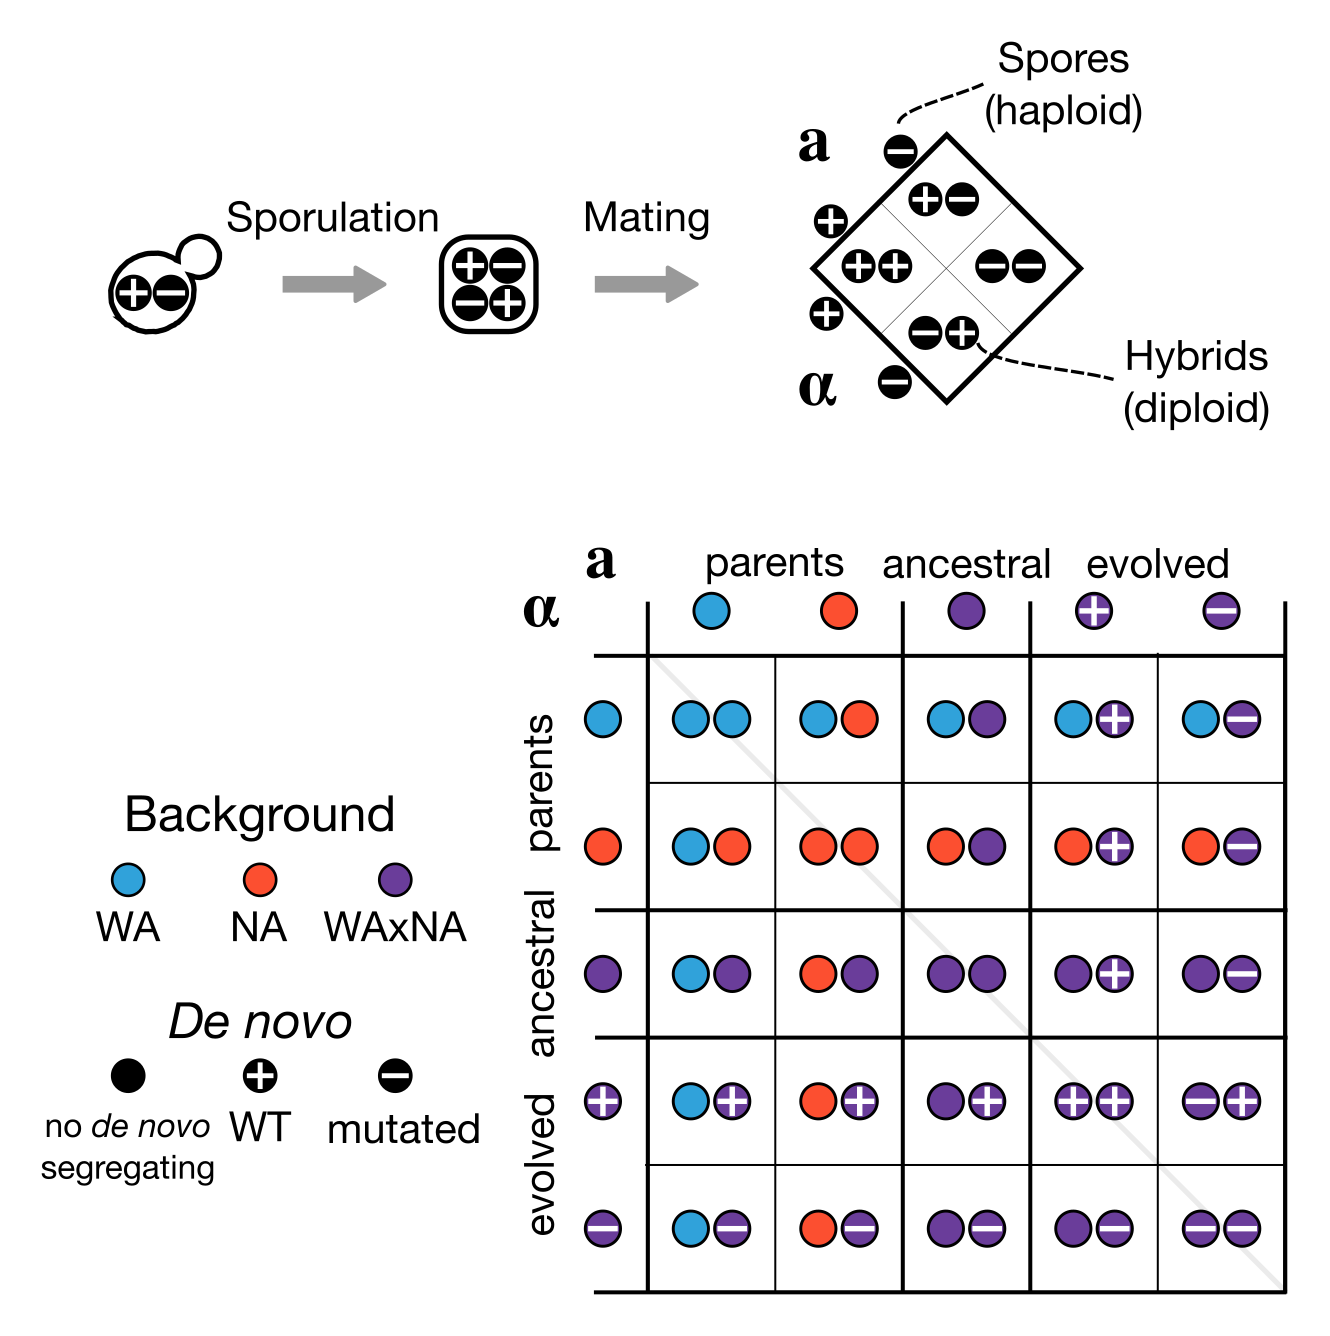

In [20]:
from IPython.display import Image
Image(filename=dir_paper+'figures/figure4/figure4A_schematic_submission.png', retina=True)

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


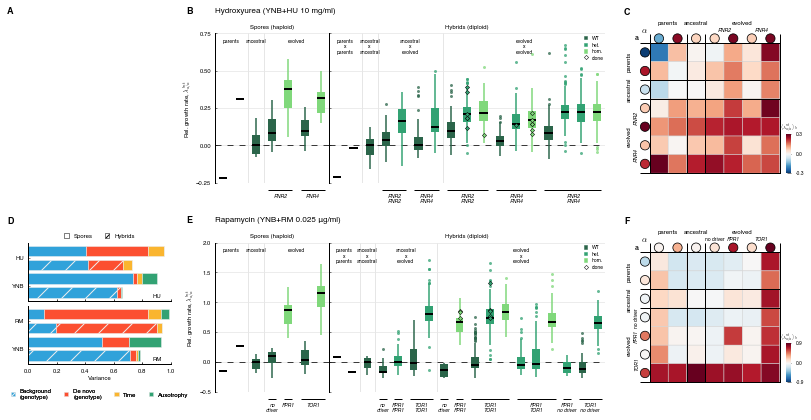

In [15]:
param='growth_rate'

fig = plt.figure(figsize=(12, 6), dpi=300)

grid = gridspec.GridSpec(2, 3, width_ratios=[1.1,3,1], hspace=0.4, wspace=0.2)

gs = {}
gs['schematic'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,0])
gs['variance'] = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios=[5,5,2], subplot_spec=grid[1,0], hspace=0.1)
gs[('HU','heatmap')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,2])
gs[('HU','barplot')] = gridspec.GridSpecFromSubplotSpec(1, 24, subplot_spec=grid[0,1], wspace=0)
gs[('RM','heatmap')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1,2])
gs[('RM','barplot')] = gridspec.GridSpecFromSubplotSpec(1, 24, subplot_spec=grid[1,1], wspace=0)

### Schematic ###
ax = plt.subplot(gs['schematic'][:])
ax.text(-0.1, 1.15,  chr(ord('A')), transform=ax.transAxes,
        fontsize=9, fontweight='bold', va='center', ha='right')
ax.axis('off')

### Box plots ###
groups_sp = spores_norm_df.groupby(['selection','environment'])
groups_hy = hybrids_norm_df.groupby(['selection','environment'])
groups_cl = clone_norm_df.groupby(['selection','environment'])

for (ii, (env_evo, env_test)) in enumerate([('HU','HU'),('RM','RM')]):
    
    # group by evolution and test environment
    S = groups_sp.get_group((env_evo, env_test))
    H = groups_hy.get_group((env_evo, env_test))
    C = groups_cl.get_group((env_evo, env_test))
    
    # filter by dictionary
    S = filter_spores(S, env_evo)
    H = filter_hybrids(H, env_evo)
    
    # apply sorting ranks to reorder rows
    S = sort_spores(S, env_evo)
    H = sort_hybrids(H, env_evo)
    
    ### spores barplot ###
    ax1 = plt.subplot(gs[(env_evo,'barplot')][:7])

    ax1.text(-0.2, 1.15,  chr(3*ii + ord('B')), transform=ax1.transAxes,
             fontsize=9, fontweight='bold', va='center', ha='right')
    
    ax1.text(0, 1.15, config.environment['long_label'][env_test], transform=ax1.transAxes,
             fontsize=8, va='center', ha='left')
    
    S = S.groupby(['group','background','gene','genotype_short','tetrad','spore'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']\
    .unstack(level=['group','background','gene','genotype_short'])
    S_ref = S.ix[:,'ancestral'].median().values
    S = S-S_ref
    
    bp = S.plot(ax=ax1, kind='box', by='group', return_type='dict',
                labels=S.columns.get_level_values('group'))

    colors = [config.spores_gt_short['color'][env_evo][x] for x in S.columns.get_level_values('genotype_short')]
    plot.boxplot_custom(bp, ax1, colors=colors, hatches=[' ']*10)
        
    ax1.set_title('Spores (haploid)', fontsize=6, y=1)
    ax1.set_xlabel('')
    ax1.set_ylabel(r'Rel. growth rate, $\lambda^{bnt}_{a/\alpha}$', fontsize=6, labelpad=2)

    ### hybrids barplot ###
    ax2 = plt.subplot(gs[(env_evo,'barplot')][7:], sharey=ax1)
    
    H = H.groupby(['group','background','gene','genotype_short','tetrad','spore'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']\
    .unstack(level=['group','background','gene','genotype_short'])
    ix_use = pd.MultiIndex.from_tuples([[('ancestral', 'ancestral')]], names=['group'])
    H_ref = H.loc[:,H.columns.get_level_values('group').isin(ix_use.get_level_values(0))].median().squeeze()
    H = H-H_ref
    
    C = C.groupby(['group','background','gene','genotype_short','isolate'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']
    C_ref = C[('ancestral', 'ancestral')].median()

    C = C-C_ref
    C = C.unstack(level=['group','background','gene','genotype_short'])
    C = C.loc[:,(C.columns.get_level_values('group').isin([('evolved','evolved')])\
                 &~(C.columns.get_level_values('gene').isin([('','')])))]
    C = C.reindex(columns=H.columns)
    C = C.dropna(how='all')

    bp = H.plot(ax=ax2, kind='box', by='group', return_type='dict', 
                labels=H.columns.get_level_values('group'))

    colors = [config.hybrids_gt_short['color'][env_evo][x] for x in H.columns.get_level_values('genotype_short')]
    plot.boxplot_custom(bp, ax2, colors=colors, hatches=[' ']*30)

    for i,d in enumerate(C):
        y = C[d]
        x = [i+1]*len(y)
        ax2.plot(x, y, 
                 mfc=config.hybrids_gt_short['color'][env_evo][d[-1]], mec='k', 
                 ms=3, marker="D", linestyle="None", zorder=6)
    
    ax2.set_title('Hybrids (diploid)', fontsize=6)
    ax2.set_xlabel('')
    ax2.set_ylabel('', fontsize=6)
    
    wt_artist = patches.Rectangle((0,0), width=1, height=1, color=config.hybrids_gt_short['color'][env_evo][('+','+')])
    het_artist = patches.Rectangle((0,0), width=1, height=1, color=config.hybrids_gt_short['color'][env_evo][('+','-')])
    hom_artist = patches.Rectangle((0,0), width=1, height=1, color=config.hybrids_gt_short['color'][env_evo][('-','-')])
    clone_artist = lines.Line2D((0,.75),(0,0), mec='k', mfc='w', marker='D', markersize=3, linestyle='')

    leg = ax2.legend([wt_artist,het_artist,hom_artist,clone_artist], 
                     ['WT','het.','hom.','clone'], ncol=1, 
                     frameon=False, loc='upper right',
                     borderaxespad=0, handlelength=0.75, 
                     prop={'size':5}, labelspacing=.32)
        
    # Grid
    for ax, g in zip([ax1,ax2],[S,H]):
        ### horizontal ###
        ax.yaxis.grid(ls="-", lw=.75, color="0.9", zorder=0)
        ax.axhline(y=0., c='k', ls="--", lw=.75, zorder=1)
        ax.set_axisbelow(True)
        
        ### vertical ###
        ## background
        xstart, xend, xlabels = plot.set_custom_labels(g.columns, 0)
        # labels
        for k, v in xlabels.iteritems():
            ax.annotate('\nx\n'.join(k) if isinstance(k, tuple) else k, 
                        xy=(v+1, 0.97), xycoords=("data", "axes fraction"),
                        ha='center', va='top', annotation_clip=False, fontsize=5)
        # grid
        xgrid=[xst+1.5 for xst in list(set(xstart.values()))]
        [ax.axvline(x, lw=1.0, ls='-', color='0.9', zorder=0) for x in xgrid]

        ## gene
        xend, xstart, xlabels = plot.set_custom_labels(g.columns, 2)
        
        transform = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        for k in xlabels:
            if (k!='') & (k!=('','')):
                if abs(xstart[k]-xend[k])>0:
                    line = lines.Line2D([xstart[k]+.75,xend[k]+1.25], [-.05,-.05], 
                                        color='k', lw=1, transform=transform)
                else:
                    line = lines.Line2D([xstart[k]+.75,xend[k]+1.25], [-.05,-.05], 
                                        color='k', lw=1, transform=transform)
                ax.add_line(line)
                line.set_clip_on(False)
        
        ax.set_xticks([x+1 for x in xlabels.values()], minor=False)
        di = {u'no driver': u'no\ndriver', u'/': u'',
              u'\nRNR2': u'RNR2\nRNR2', u'\nRNR4': u'RNR4\nRNR4',
              u'\nno driver': u'no\ndriver', u'no driver\nno driver': u'no\ndriver',
              u'\nFPR1': u'FPR1\nFPR1', u'\nTOR1': u'TOR1\nTOR1'}
        xlabels = ['\n'.join(k) if isinstance(k, tuple) else k for k in xlabels.keys()]
        xlabels = [di[x] if x in di else x for x in xlabels]
        ax.set_xticklabels(xlabels, minor=False, fontsize=5, style='italic', va='top')
                
        ax.tick_params(axis='x', which='minor', size=0, pad=-30)
        ax.tick_params(axis='x', which='major', size=0, pad=10)
        ax.tick_params(axis='y', which='major', labelsize=6)
        
        if env_evo=='HU':
            ax.set_ylim(-0.25,0.75)
            ax.yaxis.set_major_locator( MaxNLocator(nbins = 5) )
            ax.yaxis.set_minor_locator( MaxNLocator(nbins = 5) )
        elif env_evo=='RM':
            ax.set_ylim(-0.5,2.0)
            ax.yaxis.set_major_locator( MaxNLocator(nbins = 5) )
            ax.yaxis.set_minor_locator( MaxNLocator(nbins = 5) )

### Heatmaps ###
for (ii, (env_evo, env_test)) in enumerate([('HU','HU'),('RM','RM')]):
    
    # group by evolution and test environment
    S = groups_sp.get_group((env_evo, env_test))
    H = groups_hy.get_group((env_evo, env_test))
    
    # apply sorting ranks to reorder rows
    S = sort_spores(S, env_evo)
    H = sort_hybrids(H, env_evo)

    ax = plt.subplot(gs[(env_evo,'heatmap')][:])
        
    ax.text(-0.15, 1.24,  chr(3*ii + ord('C')), transform=ax.transAxes,
             fontsize=9, fontweight='bold', va='center', ha='right')
    
    # spores
    S = S.groupby([u'mating',u'group',u'background',u'genotype_short',u'gene'],
                    sort=False).agg(np.mean)[param]
    S_ref = S.ix[:,'ancestral'].mean()
    S = S-S_ref
    
    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    vmax = max(S.min(), S.max())
    vmin = -vmax

    plot.heatmap_spores(S, ax, title, 
                        xlabel, ylabel, xticklabels, yticklabels, 
                        cmap=plt.cm.RdBu_r, vmin=vmin, vmax=vmax, radius=0.25)
    
    # hybrids    
    H = H.groupby([u'group_MATa',u'background_MATa',u'gene_MATa',u'genotype_short_MATa',
                   u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα'],
                    sort=False).agg(np.mean)[param]
    H = H.unstack(level=[u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα'])
    H_ref = H.loc['ancestral','ancestral'].loc['WAxNA','WAxNA'].values.squeeze()
    H = H-H_ref

    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    vmax = max(np.nanmin(H), np.nanmax(H), key=abs)#H.values.max()
    vmin = -vmax
    legend_title = r'$\langle \lambda^{nt}_{a/\alpha}\rangle_b$'
    
    plot.heatmap_hybrids(H, ax, title,
                         xlabel, ylabel, xticklabels, yticklabels, 
                         fold=False, legend_title=legend_title, cmap=plt.cm.RdBu_r, 
                         vmin=vmin, vmax=vmax, pad=30)
    
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    
    ax.annotate(r'$\mathbf{a}$', xy=(-0.1, 1.01), xycoords=('axes fraction', 'axes fraction'),
                 ha='center', va='bottom', annotation_clip=False, weight='bold', fontsize=8)
    ax.annotate(r'$\mathbf{\alpha}$', xy=(-0.01, 1.1), xycoords=('axes fraction', 'axes fraction'),
                 ha='right', va='center', annotation_clip=False, weight='bold', fontsize=8)
    
    ## gene
    # labels
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, 2)
    for k, v in xlabels.iteritems():
        ax.annotate(k, xy=(v+0.5, 1.12), xycoords=("data", "axes fraction"),
                    ha='center', va='top', annotation_clip=False, 
                    style=('italic' if k!='no driver' else 'normal'), fontsize=5)
    ystart, yend, ylabels = plot.set_custom_labels(H.index, 2)
    for k, v in xlabels.iteritems():
        ax.annotate(k, xy=(-0.12, v+0.5), xycoords=("axes fraction", "data"),
                    ha='left', va='center', annotation_clip=False, 
                    style=('italic' if k!='no driver' else 'normal'), fontsize=5, rotation=90)
    
    ## background
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, 0)
    ax.set_xticks([x+0.5 for x in xlabels.values()], minor=False)
    ax.set_xticklabels(xlabels.keys(), minor=False, fontsize=6)
    xgrid=[xst+1. for xst in list(set(xstart.values()))]
    [ax.axvline(g, lw=1, ls="-", color="black") for g in xgrid]
    
    ystart, yend, ylabels= plot.set_custom_labels(H.columns, 0)
    ax.set_yticks([y+0.5 for y in ylabels.values()], minor=False)
    ax.set_yticklabels(ylabels.keys(), minor=False, fontsize=6, rotation=90)
    ygrid=[yst+1. for yst in list(set(ystart.values()))]
    [ax.axhline(g, lw=1, ls="-", color="black") for g in ygrid]

    for x in ([-1]+xstart.values()):
        line = lines.Line2D([x+1,x+1], [0.,-.5], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    for y in ([-1]+ystart.values()):
        line = lines.Line2D([0.,-.5], [y+1,y+1], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ax.tick_params(axis='both', which='minor', size=0, pad=10)
    ax.tick_params(axis='both', which='major', size=0, pad=18)

### Variance components ###
sdf = spores_norm_df
sdf = sdf[sdf.group.isin(['ancestral','evolved'])]
sdf = sdf[np.isfinite(sdf[param])]

hdf = hybrids_norm_df
hdf = hdf[hdf.group.isin([('ancestral','ancestral'),('ancestral','evolved'),('evolved','evolved')])]
hdf = hdf[np.isfinite(hdf[param])]

formula = 'growth_rate ~ C(group) + C(genotype_long) + C(auxotrophy) + C(individual)'
tsdf = sdf.groupby(['selection','environment']).apply(lmm.variance_vectors, formula) 
thdf = hdf.groupby(['selection','environment']).apply(lmm.variance_vectors, formula)
df = pd.concat([tsdf['var_explained'], thdf['var_explained']], keys=['spores','hybrids'], names=['type'])
      
# fix columns
df = df.rename(
    columns={
        'C(group)':'Time',
        'C(genotype_long)':'De novo\n(genotype)',
        'C(auxotrophy)':'Auxotrophy',
        'C(individual)':'Background\n(genotype)',
    }
)

order = ['Background\n(genotype)','De novo\n(genotype)','Time','Auxotrophy']
order = [val for val in order if val in df.columns]
df = df[order]

# fix index
df = df.swaplevel('type', 'selection')
df = df.swaplevel('type', 'environment')
df = df.sort_index(level=['selection','environment','type'])
df = df.sort_index(ascending=False)

axes = {}

for ii, (env_evo, ge) in enumerate(df.groupby(level='selection')):
        
    if env_evo=='HU':
        axes[env_evo] = plt.subplot(gs['variance'][ii])
        axes[env_evo].text(-0.1, 1.375,  chr(ord('D')), transform=axes[env_evo].transAxes,
                           fontsize=9, fontweight='bold', va='center', ha='right')
    else:
        axes[env_evo] = plt.subplot(gs['variance'][ii], sharex=axes['HU'])
        
    ax = axes[env_evo]
    utils.simple_axes(ax)
    
    ge.plot(ax=ax, kind='barh', stacked=True, 
            color=[config.factors['color'][x] for x in ge.columns],
            align='center', legend=False, width=0.75)
    
    bars = ax.patches
    hatches = [config.factors['hatch'][x] for x in ge.index.get_level_values('type')]*len(ge)

    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    
    # x-axis
    ax.set_xlabel('Variance', fontsize=6, labelpad=2, visible=True)
    # y-axis
    ax.set_ylabel('')
    ystart, yend, ylabels = plot.set_custom_labels(ge.index, 1)
    ax.set_yticks(ylabels.values())
    ax.set_yticklabels(ylabels.keys(), fontsize=6)
    
    # annotate panels and axis
    ax.annotate(env_evo, xy=(0.9, 0.05), xycoords=('axes fraction', 'axes fraction'),
                ha='center', va='bottom', fontsize=6)
    
    ax.tick_params(axis='both', which='major', labelsize=6, size=2)
    
# fix x-axis labels (missing due to boxplot styling)
axes['RM'].xaxis.set_visible(True)
plt.setp(axes['RM'].get_xticklabels(), visible=True)

leg1 = ax.legend(bbox_to_anchor=(0.5, -0.65), ncol=4,
                 frameon=False, loc='lower center',
                 borderaxespad=0, handlelength=0.75, prop={'size':6})
    
s_artist = patches.Rectangle((0,0), width=1, height=1, 
                             facecolor='w', edgecolor='k')
h_artist = patches.Rectangle((0,0), width=1, height=1, hatch='///', 
                             facecolor='w', edgecolor='k')

leg2 = axes['HU'].legend([s_artist,h_artist], ['Spores','Hybrids'],
                         bbox_to_anchor=(0.5, 1.2), ncol=2, 
                         frameon=False, loc='upper center',
                         borderaxespad=0, handlelength=0.75, prop={'size':6})

ax.add_artist(leg1)

fig.savefig(dir_paper+'figures/figure4/figure4.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_paper+'figures/figure4/figure4.svg', dpi=300, bbox_inches='tight')
plt.show()

**Fig. 4:** Fitness contribution of genetic background and de novo mutations. (**A**) To determine fitness effects of background variation and *de novo* mutations in hydroxyurea (*RNR2*, *RNR4*) and rapamycin (*FPR1*, *TOR1*), we isolated individuals from ancestral and evolved populations. From these diploid cells, we sporulated and selected haploid segregants of each mating type. Spores with heterozygous mutations in *RNR2*, *RNR4* and *TOR1* were genotyped to test if they carry the wild type or mutated allele. We crossed the *MAT*a and *MAT*α versions to create hybrids (48x48 in hydroxyurea and 56x56 in rapamycin). Independent segregants were used to measure biological variability of ancestral and evolved backgrounds. All panels follow this legend. (**B** and **E**) Relative growth rate, $\lambda$, measured with respect to the ancestral population for multiple combinations (background genotype, $b$; *de novo* genotype, $n$; time, $t$; auxotrophy, $x$) and averaged over measurement replicates. Medians and 25%/75% percentiles across groups are shown, with medians as horizontal lines and colored by de novo genotype [wildtype +/+ (blue); heterozygote +/- (green); homozygote -/- (yellow)]. Outliers (circles) and isolated, selected clones with matching genotypes (diamonds) are highlighted. (**D**) Variance decomposition of the group means for spores (solid) and hybrids (hatched) that can be attributed to different components using a linear mixed model. The sum of squares is used to compare deviations in the ratio of between- and within-group variance (Fig. S12 and Table S6). (**C** and **F**) Ensemble average of the growth rate of spores  and hybrids . An extended version of the figure with all combinations and controls can be found in Figs. S10 and S11, respectively.

## Figure S10 - Background-averaged fitness effects (full matrix)

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Selection: HU, Environment: HU, Pass: 2248, Fail:   56
Selection: HU, Environment: YNB, Pass: 2248, Fail:   56
Selection: RM, Environment: RM, Pass: 2482, Fail:  654
Selection: RM, Environment: YNB, Pass: 2477, Fail:  659


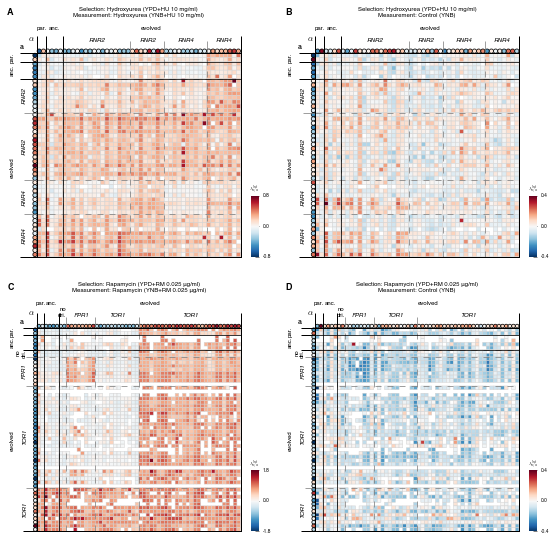

In [7]:
param='growth_rate'

fig = plt.figure(figsize=(8, 8), dpi=300)

grid = gridspec.GridSpec(2, 2, hspace=0.35, wspace=0.25)

gs = {}
gs[('HU','HU')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,0])
gs[('HU','YNB')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,1])
gs[('RM','RM')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1,0])
gs[('RM','YNB')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1,1])

groups_sp = spores_norm_df.groupby(['selection','environment'])
groups_hy = hybrids_norm_df.groupby(['selection','environment'])
groups_cl = clone_norm_df.groupby(['selection','environment'])

for (ii, (env_evo, env_test)) in enumerate([('HU','HU'),('HU','YNB'),('RM','RM'),('RM','YNB')]):
    
    # group by evolution and test environment
    S = groups_sp.get_group((env_evo, env_test))
    H = groups_hy.get_group((env_evo, env_test))
    C = groups_cl.get_group((env_evo, env_test))
    
    # apply sorting ranks to reorder rows
    S = sort_spores(S, env_evo)
    H = sort_hybrids(H, env_evo)

    ### heatmap ###
    ax = plt.subplot(gs[(env_evo, env_test)][0])
    
    ax.text(-0.115, 1.2,  chr(ii + ord('A')), transform=ax.transAxes,
            fontsize=9, fontweight='bold', va='center', ha='right')
    
    ax.text(0.5, 1.2,  
            'Selection: %s\nMeasurement: %s' %\
            (config.selection['long_label'][env_evo], config.environment['long_label'][env_test]), 
            transform=ax.transAxes,
            fontsize=6, va='center', ha='center')
    
    # spores
    S = S.groupby([u'mating',u'group',u'background',u'gene',u'genotype_short',u'tetrad',u'spore'],
                    sort=False)[param].agg(np.median).reset_index()
    S = S.set_index('mating')[param]
    S_ref = np.nanmean(S.values)
    S = S-S_ref
        
    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    vmax = max(S.min(), S.max())
    vmin = -vmax
    
    plot.heatmap_spores(S, ax, title, 
                        xlabel, ylabel, xticklabels, yticklabels, 
                        cmap=plt.cm.RdBu_r, vmin=vmin, vmax=vmax, radius=0.5)
    
    # hybrids    
    H = H.groupby([u'group_MATa',u'background_MATa',u'gene_MATa',u'genotype_short_MATa',u'tetrad_MATa',u'spore_MATa',
                   u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα',u'tetrad_MATα',u'spore_MATα'],
                    sort=False).agg(np.median)[param]
    H = H.unstack(level=[u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα',u'tetrad_MATα',u'spore_MATα'])
    H_ref = np.nanmean(H.loc['ancestral','ancestral'].loc['WAxNA','WAxNA'])
    H = H-H_ref

    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    vmax = max(np.nanmin(H), np.nanmax(H), key=abs)
    vmin = -vmax
    legend_title = r'$\lambda^{bnt}_{a/\alpha}$'
    
    plot.heatmap_hybrids(H, ax, title,
                         xlabel, ylabel, xticklabels, yticklabels, 
                         fold=False, legend_title=legend_title, cmap=plt.cm.RdBu_r, 
                         vmin=vmin, vmax=vmax, pad=30)
    
    print 'Selection: %s, Environment: %s, Pass: %4d, Fail: %4d' \
    % (env_evo, env_test, H.notnull().values.flatten().sum(), H.isnull().values.flatten().sum())
    
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    
    ax.annotate(r'$\mathbf{a}$', xy=(-0.075, 1.01), xycoords=('axes fraction', 'axes fraction'),
                 ha='center', va='bottom', annotation_clip=False, weight='bold', fontsize=8)
    ax.annotate(r'$\mathbf{\alpha}$', xy=(-0.01, 1.075), xycoords=('axes fraction', 'axes fraction'),
                 ha='right', va='center', annotation_clip=False, weight='bold', fontsize=8)
    
    ## gene + genotype
    # labels and grid
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, slice(2, 4))
    for k, v in xlabels.iteritems():
        ax.annotate(k[0].replace('no driver','no\ndri.'), 
                    xy=(v+0.5, 1.05), xycoords=("data", "axes fraction"),
                    ha='center', va='bottom', annotation_clip=False, 
                    style=('italic' if k[0]!='no driver' else 'normal'), fontsize=6)
    xgrid=[xst+1. for xst in list(set(xstart.values()))]
    [ax.axvline(g, lw=.75, ls="--", color="gray") for g in xgrid]
    for x in ([-1]+xstart.values()):
        line = lines.Line2D([x+1,x+1], [0.,-3], color='gray', ls='-', lw=.75)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ystart, yend, ylabels = plot.set_custom_labels(H.index, slice(2, 4))
    for k, v in ylabels.iteritems():
        ax.annotate(k[0].replace('no driver','no\ndri.'), 
                    xy=(-0.05, v+0.5), xycoords=("axes fraction", "data"),
                    ha='right', va='center', annotation_clip=False,  
                    style=('italic' if k[0]!='no driver' else 'normal'), fontsize=6, rotation=90)
    ygrid=[yst+1. for yst in list(set(ystart.values()))]
    [ax.axhline(g, lw=.75, ls="--", color="gray") for g in ygrid]
    for y in ([-1]+ystart.values()):
        line = lines.Line2D([0.,-3], [y+1,y+1], color='gray', ls='-', lw=.75)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ## background
    # labels and grid
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, 0)
    for k, v in xlabels.iteritems():
        ax.annotate(config.population['short_label'][k], 
                    xy=(v+0.5, config.population['pad'][k]+1), xycoords=("data", "axes fraction"),
                    ha='center', va='bottom', annotation_clip=False, fontsize=6)
    xgrid=[xst+1. for xst in list(set(xstart.values()))]
    [ax.axvline(g, lw=.75, ls="-", color="k") for g in xgrid]
    for x in ([-1]+xstart.values()):
        line = lines.Line2D([x+1,x+1], [0.,-4], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ystart, yend, ylabels = plot.set_custom_labels(H.index, 0)
    for k, v in ylabels.iteritems():
        ax.annotate(config.population['short_label'][k], 
                    xy=(-config.population['pad'][k], v+0.5), xycoords=("axes fraction", "data"),
                    ha='right', va='center', annotation_clip=False, fontsize=6, rotation=90)
    ygrid=[yst+1. for yst in list(set(ystart.values()))]
    [ax.axhline(g, lw=.75, ls="-", color="k") for g in ygrid]
    for y in ([-1]+ystart.values()):
        line = lines.Line2D([0.,-4], [y+1,y+1], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ax.tick_params(axis='both', which='minor', size=0, pad=2)
    ax.tick_params(axis='both', which='major', size=0, pad=15)

fig.savefig(dir_supp+'figures/supp_figure_pheno_cross/supp_figure_pheno_cross_extended.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_pheno_cross/supp_figure_pheno_cross_extended.svg', dpi=300, bbox_inches='tight')
plt.show()

**Fig. S10**: Fitness contribution of genetic background and *de novo* mutations. Given an ensemble of $n_b$ unique genetic backgrounds ($n_b = 48$ in hydroxyurea and $n_b = 56$ in rapamycin), we constructed a matrix of size $n_b \times n_b$ where every unique haploid background is crossed against itself and all other haploid backgrounds, and the two must be of opposite mating type (*MAT*a or *MAT*$\alpha$). Each matrix element is labeled by background genotype, $b$; *de novo* genotype, $n$; time, $t$; and auxotrophy, $x$. All symbols follow the Fig. 4A legend in the main text. Relative growth rates, $\lambda^{bntx}_{(a,\alpha)}$, are normalized with respect to the ancestral WAxNA crosses. Measurements are taken in (**A**) YNB+HU \SI{10}{\milli\gram\per\milli\litre} and (**B**) YNB; (**C**) YNB+RM \SI{0.025}{\micro\gram\per\milli\litre} and (**D**) YNB, respectively. The color scale for all matrices to the right of each panel indicates the relative fold-change with respect to the ancestral WAxNA crosses. White boxes indicate missing data due to mating inefficiency and slow growth. 

## Figure S11 - Background-averaged fitness effects (control)

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


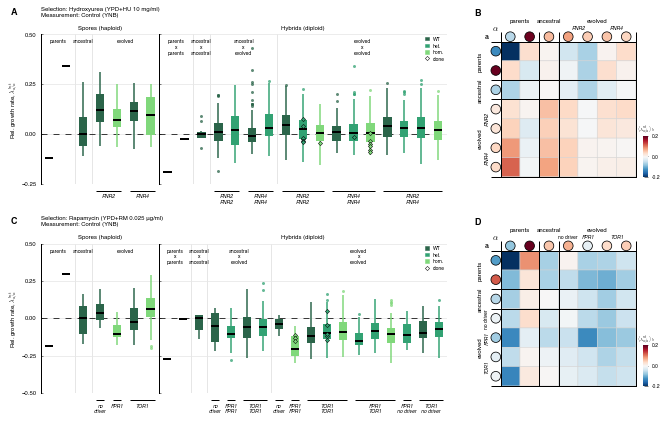

In [8]:
param='growth_rate'

fig = plt.figure(figsize=(9.5, 6), dpi=300)

grid = gridspec.GridSpec(2, 2, width_ratios=[3,1], hspace=0.4, wspace=0.2)

gs = {}
gs[('HU','barplot')] = gridspec.GridSpecFromSubplotSpec(1, 24, subplot_spec=grid[0,0], wspace=0)
gs[('HU','heatmap')] = gridspec.GridSpecFromSubplotSpec(1, 1,subplot_spec=grid[0,1])
gs[('RM','barplot')] = gridspec.GridSpecFromSubplotSpec(1, 24, subplot_spec=grid[1,0], wspace=0)
gs[('RM','heatmap')] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1,1])

### Box plots ###
groups_sp = spores_norm_df.groupby(['selection','environment'])
groups_hy = hybrids_norm_df.groupby(['selection','environment'])
groups_cl = clone_norm_df.groupby(['selection','environment'])

for (ii, (env_evo, env_test)) in enumerate([('HU','YNB'),('RM','YNB')]):
    
    # group by evolution and test environment
    S = groups_sp.get_group((env_evo, env_test))
    H = groups_hy.get_group((env_evo, env_test))
    C = groups_cl.get_group((env_evo, env_test))
    
    # filter by dictionary
    S = filter_spores(S, env_evo)
    H = filter_hybrids(H, env_evo)
    
    # apply sorting ranks to reorder rows
    S = sort_spores(S, env_evo)
    H = sort_hybrids(H, env_evo)
    
    ### spores barplot ###
    ax1 = plt.subplot(gs[(env_evo,'barplot')][:7])

    ax1.text(-0.2, 1.15,  chr(2*ii + ord('A')), transform=ax1.transAxes,
             fontsize=9, fontweight='bold', va='center', ha='right')
    
    ax1.text(0, 1.15,  
             'Selection: %s\nMeasurement: %s' %\
             (config.selection['long_label'][env_evo], config.environment['long_label'][env_test]), 
             transform=ax1.transAxes,
             fontsize=6, va='center', ha='left')
    
    S = S.groupby(['group','background','gene','genotype_short','tetrad','spore'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']\
    .unstack(level=['group','background','gene','genotype_short'])
    S_ref = S.ix[:,'ancestral'].median().values
    S = S-S_ref
    
    bp = S.plot(ax=ax1, kind='box', by='group', return_type='dict',
                labels=S.columns.get_level_values('group'))

    plot.boxplot_custom(bp, ax1,
                        colors=[config.spores_gt_short['color'][env_evo][x] for x in S.columns.get_level_values('genotype_short')],
                        hatches=[' ']*10)
    
    ax1.set_title('Spores (haploid)', fontsize=6)
    ax1.set_xlabel('')
    ax1.set_ylabel(r'Rel. growth rate, $\lambda^{bnt}_{a/\alpha}$', fontsize=6, labelpad=2)

    ### hybrids barplot ###
    ax2 = plt.subplot(gs[(env_evo,'barplot')][7:], sharey=ax1)
    
    H = H.groupby(['group','background','gene','genotype_short','tetrad','spore'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']\
    .unstack(level=['group','background','gene','genotype_short'])
    ix_use = pd.MultiIndex.from_tuples([[('ancestral', 'ancestral')]], names=['group'])
    H_ref = H.loc[:,H.columns.get_level_values('group').isin(ix_use.get_level_values(0))].median().squeeze()
    H = H-H_ref
    
    C = C.groupby(['group','background','gene','genotype_short','isolate'], sort=False)[param]\
    .agg([np.mean, np.median, np.std, 'count'])['mean']
    C_ref = C[('ancestral', 'ancestral')].median()

    C = C-C_ref
    C = C.unstack(level=['group','background','gene','genotype_short'])
    C = C.loc[:,(C.columns.get_level_values('group').isin([('evolved','evolved')])\
                 &~(C.columns.get_level_values('gene').isin([('','')])))]
    C = C.reindex(columns=H.columns)
    C = C.dropna(how='all')

    bp = H.plot(ax=ax2, kind='box', by='group', return_type='dict', 
                labels=H.columns.get_level_values('group'))

    plot.boxplot_custom(bp, ax2, 
                        colors=[config.hybrids_gt_short['color'][env_evo][x] for x in H.columns.get_level_values('genotype_short')],
                        hatches=[' ']*30)

    for i,d in enumerate(C):
        y = C[d]
        x = [i+1]*len(y)
        ax2.plot(x, y, 
                 mfc=config.hybrids_gt_short['color'][env_evo][d[-1]], mec='k', 
                 ms=3, marker='D', linestyle="None", zorder=6)
    
    ax2.set_title('Hybrids (diploid)', fontsize=6)
    ax2.set_xlabel('')
    ax2.set_ylabel('', fontsize=6)
    
    wt_artist = patches.Rectangle((0,0), width=1, height=1, color=config.hybrids_gt_short['color'][env_evo][('+','+')])
    het_artist = patches.Rectangle((0,0), width=1, height=1, color=config.hybrids_gt_short['color'][env_evo][('+','-')])
    hom_artist = patches.Rectangle((0,0), width=1, height=1, color=config.hybrids_gt_short['color'][env_evo][('-','-')])
    clone_artist = lines.Line2D((0,1),(0,0), mec='k', mfc='w', marker='D', markersize=3, linestyle='')

    leg = ax2.legend([wt_artist,het_artist,hom_artist,clone_artist], 
                     ['WT','het.','hom.','clone'], ncol=1, 
                     frameon=False, loc='upper right',
                     borderaxespad=0, handlelength=0.75, 
                     prop={'size':5}, labelspacing=.32)
        
    # Grid
    for ax, g in zip([ax1,ax2],[S,H]):
        ### horizontal ###
        ax.yaxis.grid(ls="-", lw=.75, color="0.9", zorder=-1)
        ax.axhline(y=0., c='k', ls="--", lw=.75, zorder=1)
        ax.set_axisbelow(True)
        
        ### vertical ###
        ## background
        xstart, xend, xlabels = plot.set_custom_labels(g.columns, 0)
        # labels
        for k, v in xlabels.iteritems():
            ax.annotate('\nx\n'.join(k) if isinstance(k, tuple) else k, 
                        xy=(v+1, 0.97), xycoords=("data", "axes fraction"),
                        ha='center', va='top', annotation_clip=False, fontsize=5)
        # grid
        xgrid=[xst+1.5 for xst in list(set(xstart.values()))]
        [ax.axvline(x, lw=1.0, ls='-', color="0.9", zorder=0) for x in xgrid]

        ## gene
        xend, xstart, xlabels = plot.set_custom_labels(g.columns, 2)
        
        transform = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        for k in xlabels:
            if (k!='') & (k!=('','')):
                if abs(xstart[k]-xend[k])>0:
                    line = lines.Line2D([xstart[k]+.75,xend[k]+1.25], [-.05,-.05], 
                                        color='k', lw=1, transform=transform)
                else:
                    line = lines.Line2D([xstart[k]+.75,xend[k]+1.25], [-.05,-.05], 
                                        color='k', lw=1, transform=transform)
                ax.add_line(line)
                line.set_clip_on(False)
        
        ax.set_xticks([x+1 for x in xlabels.values()], minor=False)
        di = {u'no driver': u'no\ndriver', u'/': u'',
              u'\nRNR2': u'RNR2\nRNR2', u'\nRNR4': u'RNR4\nRNR4',
              u'\nno driver': u'no\ndriver', u'no driver\nno driver': u'no\ndriver',
              u'\nFPR1': u'FPR1\nFPR1', u'\nTOR1': u'TOR1\nTOR1'}
        xlabels = ['\n'.join(k) if isinstance(k, tuple) else k for k in xlabels.keys()]
        xlabels = [di[x] if x in di else x for x in xlabels]
        ax.set_xticklabels(xlabels, minor=False, fontsize=5, style='italic', va='top')
                
        ax.tick_params(axis='x', which='minor', size=0, pad=-30)
        ax.tick_params(axis='x', which='major', size=0, pad=10)
        ax.tick_params(axis='y', which='major', labelsize=6)
        
        if env_evo=='HU':
            ax.set_ylim(-0.25,0.5)
            ax.yaxis.set_major_locator( MaxNLocator(nbins = 4) )
            ax.yaxis.set_minor_locator( MaxNLocator(nbins = 4) )
        elif env_evo=='RM':
            ax.set_ylim(-0.5,0.5)
            ax.yaxis.set_major_locator( MaxNLocator(nbins = 4) )
            ax.yaxis.set_minor_locator( MaxNLocator(nbins = 4) )

### Heatmaps ###
for (ii, (env_evo, env_test)) in enumerate([('HU','YNB'),('RM','YNB')]):
    
    # group by evolution and test environment
    S = groups_sp.get_group((env_evo, env_test))
    H = groups_hy.get_group((env_evo, env_test))
    
    # apply sorting ranks to reorder rows
    S = sort_spores(S, env_evo)
    H = sort_hybrids(H, env_evo)

    ax = plt.subplot(gs[(env_evo,'heatmap')][:])
        
    ax.text(-0.15, 1.21,  chr(2*ii + ord('B')), transform=ax.transAxes,
             fontsize=9, fontweight='bold', va='center', ha='right')
    
    # spores
    S = S.groupby([u'mating',u'group',u'background',u'genotype_short',u'gene'],
                    sort=False).agg(np.mean)[param]
    S_ref = S.ix[:,'ancestral'].mean()
    S = S-S_ref
    
    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    vmax = max(S.min(), S.max())
    vmin = -vmax

    plot.heatmap_spores(S, ax, title, 
                        xlabel, ylabel, xticklabels, yticklabels, 
                        cmap=plt.cm.RdBu_r, vmin=vmin, vmax=vmax, radius=0.25)
    
    # hybrids    
    H = H.groupby([u'group_MATa',u'background_MATa',u'gene_MATa',u'genotype_short_MATa',
                   u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα'],
                    sort=False).agg(np.mean)[param]
    H = H.unstack(level=[u'group_MATα',u'background_MATα',u'gene_MATα',u'genotype_short_MATα'])
    H_ref = H.loc['ancestral','ancestral'].loc['WAxNA','WAxNA'].values.squeeze()
    H = H-H_ref

    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
    vmax = max(np.nanmin(H), np.nanmax(H), key=abs)
    vmin = -vmax
    legend_title = r'$\langle \lambda^{nt}_{a/\alpha}\rangle_b$'
    
    plot.heatmap_hybrids(H, ax, title,
                         xlabel, ylabel, xticklabels, yticklabels, 
                         fold=False, legend_title=legend_title, cmap=plt.cm.RdBu_r, 
                         vmin=vmin, vmax=vmax, pad=30)
    
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    
    ax.annotate(r'$\mathbf{a}$', xy=(-0.1, 1.01), xycoords=('axes fraction', 'axes fraction'),
                 ha='center', va='bottom', annotation_clip=False, weight='bold', fontsize=8)
    ax.annotate(r'$\mathbf{\alpha}$', xy=(-0.01, 1.1), xycoords=('axes fraction', 'axes fraction'),
                 ha='right', va='center', annotation_clip=False, weight='bold', fontsize=8)
    
    ## gene
    # labels
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, 2)
    for k, v in xlabels.iteritems():
        ax.annotate(k, xy=(v+0.5, 1.12), xycoords=("data", "axes fraction"),
                    ha='center', va='top', annotation_clip=False, 
                    style=('italic' if k!='no driver' else 'normal'), fontsize=5)
    ystart, yend, ylabels = plot.set_custom_labels(H.index, 2)
    for k, v in xlabels.iteritems():
        ax.annotate(k, xy=(-0.12, v+0.5), xycoords=("axes fraction", "data"),
                    ha='left', va='center', annotation_clip=False, 
                    style=('italic' if k!='no driver' else 'normal'), fontsize=5, rotation=90)
    
    ## background
    # labels and grid
    xstart, xend, xlabels = plot.set_custom_labels(H.columns, 0)
    ax.set_xticks([x+0.5 for x in xlabels.values()], minor=False)
    ax.set_xticklabels(xlabels.keys(), minor=False, fontsize=6)
    xgrid=[xst+1. for xst in list(set(xstart.values()))]
    [ax.axvline(g, lw=1, ls="-", color="black") for g in xgrid]
    
    ystart, yend, ylabels= plot.set_custom_labels(H.columns, 0)
    ax.set_yticks([y+0.5 for y in ylabels.values()], minor=False)
    ax.set_yticklabels(ylabels.keys(), minor=False, fontsize=6, rotation=90)
    ygrid=[yst+1. for yst in list(set(ystart.values()))]
    [ax.axhline(g, lw=1, ls="-", color="black") for g in ygrid]

    for x in ([-1]+xstart.values()):
        line = lines.Line2D([x+1,x+1], [0.,-.5], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    for y in ([-1]+ystart.values()):
        line = lines.Line2D([0.,-.5], [y+1,y+1], color='k', lw=1)
        ax.add_line(line)
        line.set_clip_on(False)
    
    ax.tick_params(axis='both', which='minor', size=0, pad=10)
    ax.tick_params(axis='both', which='major', size=0, pad=18)

fig.savefig(dir_supp+'figures/supp_figure_pheno_cross/supp_figure_pheno_cross_reduced.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_pheno_cross/supp_figure_pheno_cross_reduced.svg', dpi=300, bbox_inches='tight')
plt.show()

**Fig. S11:** Background-averaged fitness effects. The legend follows Fig. 4A in the main text.
(**A** and **C**) Relative growth rate, $\lambda$, measured in a control environment (YNB) for cells selected in hydroxyurea (A) and rapamycin (C). Measurements are normalized with respect to the ancestral population for multiple combinations (background genotype, $b$; *de novo* genotype, $n$; time, $t$; auxotrophy, $x$) and averaged over measurement replicates. Medians and 25%/75% percentiles across groups are shown, with medians as horizontal lines and colored by \textit{de novo} genotype [wildtype +/+ (red); heterozygote +/- (blue); homozygote -/- (green)]. Outliers (circles) and isolated, selected clones with matching genotypes (diamonds) are highlighted.
(**B** and **D**) Ensemble average of the growth rate of spores, ${\langle \lambda^{nt} \rangle}^b_{\{a,\alpha\}}$, and hybrids, ${\langle \lambda^{nt} \rangle}^b_{a/\alpha}$. The color scale for all matrices to the right of each panel indicates the relative fold-change with respect to the ancestral WAxNA crosses.

## Figure S12 - Analysis of variance

### Linear mixed model (frequentist)

0 0
0 1
1 0
1 1
2 0
2 1
3 0
3 1


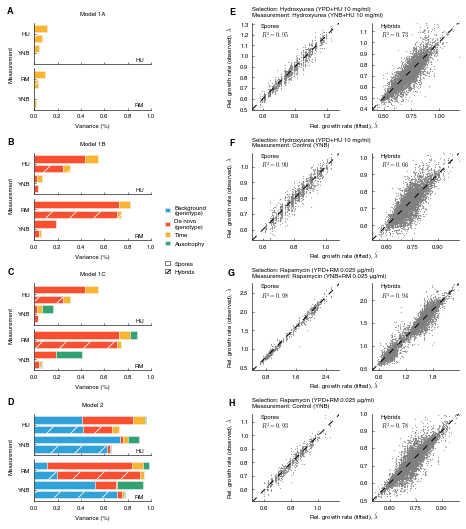

In [9]:
import statsmodels.api as sm

param='growth_rate'

sdf = spores_norm_df
sdf = sdf[sdf.group.isin(['ancestral','evolved'])]
sdf = sdf[np.isfinite(sdf[param])]

hdf = hybrids_norm_df
hdf = hdf[hdf.group.isin([('ancestral','ancestral'),('ancestral','evolved'),('evolved','evolved')])]
hdf = hdf[np.isfinite(hdf[param])]

formulas = {'Model 1A': 'growth_rate ~ C(group)',
            'Model 1B': 'growth_rate ~ C(group) + C(genotype_long)',
            'Model 1C': 'growth_rate ~ C(group) + C(genotype_long) + C(auxotrophy)',
            'Model 2': 'growth_rate ~ C(group) + C(genotype_long) + C(auxotrophy) + C(individual)'}

fig = plt.figure(figsize=(7, 8), dpi=300)

grid = gridspec.GridSpec(4, 2, width_ratios=[1,2], hspace=0.5, wspace=0.5)

gs = {}
for ii, formula in enumerate(['Model 1A', 'Model 1B', 'Model 1C', 'Model 2']):
    gs[('anova', formula)] = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid[ii,0], hspace=0.1)
    
for ii, (env_evo, env_test) in enumerate([('HU','HU'),('HU','YNB'),('RM','RM'),('RM','YNB')]):
    gs[('fit', (env_evo, env_test))] = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=grid[ii,1], wspace=0.05)

model_s = {}
model_h = {}
anova_s = {}
anova_h = {}

for ii, formula in enumerate(['Model 1A', 'Model 1B', 'Model 1C', 'Model 2']):

    model_s[formula] = sdf.groupby(['selection','environment']).apply(lmm.run_anova, formula=formulas[formula]) 
    model_h[formula] = hdf.groupby(['selection','environment']).apply(lmm.run_anova, formula=formulas[formula])
    anova_s[formula] = sdf.groupby(['selection','environment']).apply(lmm.variance_vectors, formula=formulas[formula])
    anova_h[formula] = hdf.groupby(['selection','environment']).apply(lmm.variance_vectors, formula=formulas[formula])
    df = pd.concat([anova_s[formula], anova_h[formula]], 
                   keys=['spores','hybrids'], names=['type'])
    
    df = df['var_explained']
    
    # fix columns
    df = df.rename(
        columns={
            'C(group)':'Time',
            'C(genotype_long)':'De novo\n(genotype)',
            'C(auxotrophy)':'Auxotrophy',
            'C(individual)':'Background\n(genotype)',
            'C(replicate)':'measurement\nerror'
        }
    )
    
    order = ['Background\n(genotype)','De novo\n(genotype)','Time','Auxotrophy']#,'measurement\nerror']
    order = [val for val in order if val in df.columns]
    df = df[order]
    
    # fix index
    df = df.swaplevel('type', 'selection')
    df = df.swaplevel('type', 'environment')
    df = df.sort_index(level=['selection','environment','type'])
    df = df.sort_index(ascending=False)
    
    for jj, (env_evo, ge) in enumerate(df.groupby(level='selection')):
        print ii,jj
        if jj==0:
            ax = plt.subplot(gs[('anova', formula)][jj])
            ax.text(-0.175, 1.285, chr(ii + ord('A')), transform=ax.transAxes,
                    fontsize=9, fontweight='bold', va='center', ha='right')
            ax.text(.5, 1.285, formula, transform=ax.transAxes,
                    fontsize=6, va='top', ha='center')
        else:
            ax = plt.subplot(gs[('anova', formula)][jj], sharex=ax)
        utils.simple_axes(ax)

        ge.plot(ax=ax, kind='barh', stacked=True, 
                color=[config.factors['color'][x] for x in ge.columns],
                align='center', legend=False, width=0.75)
    
        bars = ax.patches
        hatches = [config.factors['hatch'][x] for x in ge.index.get_level_values('type')]*len(ge)

        for bar, hatch in zip(bars, hatches):
            bar.set_hatch(hatch)
            
        # x-axis
        ax.set_xlabel('Variance (%)', fontsize=6)
        ax.set_xlim((0,1))
#         xticks = FormatStrFormatter('%1.1f%')
#         ax.xaxis.set_major_formatter(xticks)
#         vals = ax.get_xticks()
#         ax.set_xticklabels(['{3d}%'.format(x*100) for x in vals])
        # manipulate
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
        
        # y-axis
        ax.set_ylabel('', fontsize=6)
        if jj==0:
            ax.annotate(r'Measurement', 
                        xy=(-0.175, 0.), xycoords="axes fraction",
                        va='center', ha='right', annotation_clip=False, fontsize=6, rotation=90)
        ystart, yend, ylabels = plot.set_custom_labels(ge.index, 1)
        ax.set_yticks(ylabels.values())
        ax.set_yticklabels(ylabels.keys(), fontsize=6)
        
        # annotate panels and axis
        ax.annotate(env_evo, xy=(0.9, 0.05), xycoords=('axes fraction', 'axes fraction'),
                    ha='center', va='bottom', fontsize=6)
        
ax = plt.subplot(gs[('anova', 'Model 2')][0])

leg1 = ax.legend(bbox_to_anchor=(1.1, 5), ncol=1, 
                 frameon=False, loc='lower left', borderaxespad=0.,
                 handlelength=0.75, prop={'size':6})

# # fix x-axis labels (missing due to boxplot styling)
# axes['RM'].xaxis.set_visible(True)
# plt.setp(axes['RM'].get_xticklabels(), visible=True)

ax = plt.subplot(gs[('anova', 'Model 2')][0])

s_artist = patches.Rectangle((0,0), width=1, height=1, 
                             facecolor='w', edgecolor='k')
h_artist = patches.Rectangle((0,0), width=1, height=1, hatch='///', 
                             facecolor='w', edgecolor='k')

leg2 = ax.legend([s_artist,h_artist], ['Spores','Hybrids'],
                 bbox_to_anchor=(1.1, 4.75), ncol=1, 
                 frameon=False, loc='upper left', borderaxespad=0., 
                 handlelength=0.75, prop={'size':6})

ax.add_artist(leg1)

formula = 'Model 2'

for jj, ((env_evo, env_test), g) in enumerate(model_s[formula].groupby(level=['selection','environment'])):
        
    for kk, (label, model, data, marker) in enumerate(zip(['Spores', 'Hybrids'], 
                                                          [model_s[formula], model_h[formula]],
                                                          [sdf, hdf],
                                                          ['o','x'])):
        
        ax = plt.subplot(gs[('fit', (env_evo,env_test))][kk])
        utils.simple_axes(ax)
        
        if kk==0:
            ax.text(-0.2, 1.125, chr(jj + ord('E')), transform=ax.transAxes,
                fontsize=9, fontweight='bold', va='center', ha='right')
            ax.annotate('Selection: %s\nMeasurement: %s' %\
                         (config.selection['long_label'][env_evo], \
                          config.environment['long_label'][env_test]), 
                        xy=(0, 1.125), xycoords="axes fraction",
                        ha='left', va='center', annotation_clip=False, fontsize=6)

        lm, anova = model.ix[(env_evo, env_test)]
        data = data.groupby(['selection','environment']).get_group((env_evo, env_test))
        
        nobs = lm.nobs
        y = data.growth_rate
        yhat = lm.fittedvalues
        ymin, ymax = y.quantile([.005, .995])
        yrange = ymax - ymin
        
        # scatter
        ax.scatter(yhat, y, facecolor='gray', s=1.5, lw=0, alpha=0.75)
        
        # fit
        line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=False)).fit().params
        fit = lambda x: line_fit[1] + line_fit[0] * x 
        ax.plot(np.linspace(ymin-.1*yrange, ymax+.1*yrange, nobs), 
                fit(np.linspace(ymin-.1*yrange, ymax+.1*yrange, nobs)), 
                label=label, color='k', ls='--', lw=1)
        
        # variance explained
        factors = [each for each in anova.index if each != 'Residual']
        var_total = np.sum([lmm.variance_explained(factor, anova) for factor in factors])
        ax.annotate('{}\n$R^2={:.2f}$'.format(label, var_total), 
                    xy=(.1, .9), xycoords="axes fraction",
                    ha='left', va='center', fontsize=6)
        
        # x-axis
        ax.set_xlim(ymin-.1*yrange, ymax+.1*yrange)
        ax.xaxis.set_major_locator( MaxNLocator(nbins = 4) )

        # y-axis
        ax.set_ylim(ymin-.1*yrange, ymax+.1*yrange)
        ax.yaxis.set_minor_locator( MaxNLocator(nbins = 4) )
        
        ax.set_aspect('equal', adjustable='box')
    
        if kk==0:
            ax.annotate(r'Rel. growth rate (fitted), $\hat{\lambda}$', 
                        xy=(1.05, -0.175), xycoords="axes fraction",
                        ha='center', va='center', annotation_clip=False, fontsize=6)
            ax.set_ylabel(r'Rel. growth rate (observed), $\lambda$', fontsize=6)
    
for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=6, size=2)
    ax.tick_params(axis='both', which='minor', labelsize=6, size=0)
        
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(.6)

fig.savefig(dir_supp+'figures/supp_figure_pheno_cross/supp_figure_pheno_cross_lmm.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/supp_figure_pheno_cross/supp_figure_pheno_cross_lmm.svg', dpi=300, bbox_inches='tight')
plt.show()

**Fig. S12:** Hierarchical analysis of variance using linear mixed models. spores $\lambda_{\{a,\alpha\}}^{bnt}$ hybrids $\lambda_{a/\alpha}^{bnt}$. (**A** to **D**) Variance decomposition for Models 1A, 1B, 1C and 2, shown as the fraction of the total variance explained. YNB+HU \SI{10}{\milli\gram\per\milli\litre} and YNB; YNB+RM \SI{0.025}{\micro\gram\per\milli\litre} and YNB. (**E** to **H**) Relative growth rates are accurately fitted by the full model (Model 2). The scatter shows predicted rates $\hat{\lambda}_{a/\alpha}$ ($y$ axis) against a test set of measurements $\lambda_{\{a,\alpha\}}$ not used for training of the model ($x$ axis).

In [ ]:
from lmer import *

ind_data = sdf[['group', 'genotype_long', 'auxotrophy', 'individual']]
dep_data = sdf['growth_rate']

me = MELD('growth_rate ~ group + genotype_long + auxotrophy', '(1|individual)', 'individual',
          dep_data, ind_data, factors = ['group', 'genotype_long','auxotrophy','individual'])
me.run_perms(200)
me.run_boots(200)

# lmer_feature('growth_rate ~ group + genotype_long + auxotrophy', sdf)

In [ ]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

formulas = {'Model 1': 'growth_rate ~ C(auxotrophy)',
            'Model 2': 'growth_rate ~ C(auxotrophy) + C(group)',
            'Model 3a': 'growth_rate ~ C(auxotrophy) + C(group) + C(genotype_long)',
            'Model 3b': 'growth_rate ~ C(auxotrophy) + C(group) + C(genotype_long) + C(individual)'}

def run_anova(df, formula, anova_type=3):
    lm = ols(formula, df).fit()
    anova = anova_lm(lm, type=anova_type)
    return pd.DataFrame({'lm':lm, 'anova':anova})
#     return pd.DataFrame.from({'lm':lm, 'anova':anova})
#     return lm, anova

# model_s[formula] = sdf.groupby(['selection','environment']).apply(run_anova, formula=formulas[formula]) 
# model_h[formula] = hdf.groupby(['selection','environment']).apply(run_anova, formula=formulas[formula])
# anova_s[formula] = model_s[formula]['anova'].apply(model.variance_vectors, axis=0)
# anova_h[formula] = model_h[formula]['anova'].apply(model.variance_vectors, axis=0)

sdf.groupby(['selection','environment']).apply(model.run_anova, formula=formulas['Model 3b'])
# model_h[formula]['anova''df']

In [ ]:
data = sdf.groupby(['selection','environment']).get_group(('HU','HU'))


fig, axes = plt.subplots(1,4, figsize=(8,2))#, sharex=True, sharey=True)

for ii, (k, m) in enumerate(lm_s[formula].groupby(level=['selection','environment'])):
    ax = axes[ii]
    
    data = sdf.groupby(['selection','environment']).get_group(k)
    lm = m.ix[k]['lm']

# ax.plot(x1, y2, 'o',label="data")
# ax.plot(x1, y_true2, 'b-', label="True")
# prstd, iv_l, iv_u = wls_prediction_std(res)
    ax.plot(data.growth_rate, lm.fittedvalues, 'r.', label="OLS")
    
# ax.plot(x1, iv_u, 'r--')
# ax.plot(x1, iv_l, 'r--')
# ax.plot(x1, resrlm.fittedvalues, 'g.-', label="RLM")
ax.legend(loc="best")

plt.show()

In [ ]:
lm=msdf[formula].ix['RM','RM']['lm']
factor_groups = spores_norm_df.groupby(['auxotrophy','group','genotype_long','individual'])
resid = lm.resid
plt.figure(figsize=(6, 6));
for ii, (values, group) in enumerate(factor_groups):
    print values
    i, j, k, l = values
#     group_num = i * 2 + j - 1  # for plotting purposes
    x = [ii] * len(group)
    plt.scatter(x, resid[group.index], #marker=symbols[j], color=colors[i - 1],
                 s=144, edgecolors='black')

plt.xlabel('Group');
plt.ylabel('Residuals');

# Lasso
We fit a sequence of models using the lasso. 

In [ ]:
import statsmodels.api as sm

mat = []
alphas = np.arange(0, 0.26, 0.05)
for alpha in alphas:
    mod = sm.OLS.from_formula(formulas['Model 3a'], sdf)
    rslt = mod.fit_regularized(alpha=alpha)
    mat.append(rslt.params)
mat = pd.DataFrame(mat, index=[str(x) for x in alphas])
print mat.T

In [ ]:
# # for m1, m2 in zip(['Model 1','Model 2a','Model 2b','Model 3a'], ['Model 2a','Model 2b','Model 3a','Model 3b']):
# for m1, m2 in zip(['Model 1','Model 2','Model 3a'], ['Model 2','Model 3a','Model 3b']):
#     lm1, anova1 = model.run_anova(formulas[m1],
#                             hdf.groupby(['selection','environment']).get_group(('RM','RM')))

#     lm2, anova2 = model.run_anova(formulas[m2],
#                             hdf.groupby(['selection','environment']).get_group(('RM','RM')))
    
#     print m1, m2, lm2.compare_f_test(lm1)

In [ ]:
# import rpy2
# %load_ext rpy2.ipython

import rpy2.robjects as robject
from rpy2.robjects import pandas2ri
pandas2ri.activate()
# robjects.r('source("model.R")')
# run_lm = robjects.globalenv['run_lm']

# x=run_lm(sdf)

In [ ]:
# from rpy2.robjects import pandas2ri
# pandas2ri.activate()
# robjects.globalenv['dataframe'] = sdf
# test1=lme4.lmer(r.formula('growth_rate~(1|individual)'),data=dataframe)
# test2=lme4.lmer(r.formula('growth_rate~(1|individual)'),data=dataframe)
# test1_sum= r.summary(test1)
# test2_sum= r.summary(test2)
# print test1_sum
# print test2_sum

In [ ]:
formulas = {'Model 1': 'growth_rate ~ 1 + (1|individual)',
            'Model 2': 'growth_rate ~ 1 + (1|individual) + C(group)',
            'Model 3': 'growth_rate ~ 1 + (1|individual) + C(group) + C(genotype_long)',
            'Model 4': 'growth_rate ~ 1 + (1|individual) + C(group) + C(genotype_long) + C(auxotrophy)'}

In [ ]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()
M = stats.lm('growth_rate~individual', data=sdf)
plt.plot(robjects.r.summary(M).rx2('coefficients'))
# robjects.globalenv['dataframe'] = sdf
# M = stats.lm('growth_rate~individual', data=base.as_symbol('dataframe'))

In [95]:
# robjects.r('''
# varcomp <- function (object) 
# {
#     vc <- lme4::VarCorr(object)
#     print(vc,comp=c("Variance"))
#     sig <- attr(vc, "sc")
#     vc.mat <- bdiag(vc)
#     if (isDiagonal(vc.mat)) {
#         vc.vec <- diag(vc.mat)
#         vc.names <- paste("D", 1:length(vc.vec), 1:length(vc.vec), 
#             sep = "")
#     }
#     else {
#         vc.vec <- as.matrix(vc.mat)[!upper.tri(vc.mat)]
#         vc.index <- which(!upper.tri(vc.mat) == TRUE, arr.ind = TRUE)
#         vc.names <- paste("D", vc.index[, 1], vc.index[, 2], 
#             sep = "")
#     }
#     res <- c(sig^2, vc.vec)
#     names(res) <- c("sigma2", vc.names)
#     return(res)
# }
# ''')

robjects.r('''
varcomp <- function (df) 
{
    # Extraction of fitted value for the alternative model fixef() extracts
    # coefficents for fixed effects mF@X returns fixed effect design matrix
#     Fixed <- fixef(df)['group'] * df@pp$X[, 'group'] + fixef(df)['time'] * df@pp$X[, 'time']

#     # Calculation of the variance in fitted values
#     VarF <- var(Fixed)

#     # An alternative way for getting the same result
#     VarF <- var(as.vector(fixef(df) %*% t(df@X)))

#     # R2GLMM(m) - marginal R2GLMM see Equ. 29 and 30 and Table 2 fixef(m0)
#     # returns the estimate for the intercept of null model
#     R2m <- VarF/(VarF + VarCorr(df)$individual[1])

#     # R2GLMM(c) - conditional R2GLMM for full model Equ. XXX, XXX
#     R2c <- (VarF + VarCorr(df)$individual[1])/
#              (VarF + VarCorr(df)$individual[1] + log(1 + 1/exp(as.numeric(fixef(df))))
#              )
    
    return(df@pp$X)
}
''')


    

r_varcomp = robjects.globalenv['varcomp']

NameError: name 'robjects' is not defined

In [ ]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
base = importr('base')
stats = importr('stats')
lme4 = importr('lme4')
varcomp = importr('varComp')
# sem = importr('piecewiseSEM')

lmm = list()
fits = list()
for formula in formulas:
    print formulas[formula]
    lmm_res = lme4.lmer(formula=formulas[formula], data=sdf, REML='false')
    lmm.append(lmm_res)
    
#     vc_fixed = lme4.VarCorr_merMod( lmm_res )
    
#     varcomps=base.c(base.unlist( base.lapply(vc, base.diag) ), # random intercept variances
#             base.attr(vc_fixed,"sc")^2)            # residual variance
    
# #     print(vc)
    print(r_varcomp(lmm_res))

# m1 = nlme.lme(fixed = robjects.Formula('growth_rate ~ background'), 
#               random = robjects.Formula('~ 1|individual'), 
#               data = sdf)
#     vc = varcomp.varComp(fixed=robjects.Formula('growth_rate ~ group + auxotrophy'), 
#                     data=sdf, 
#                     random=robjects.Formula('~ individual'))  ## still, 29 observations, as ibs handles sporadic NA
#     print(varcomp(lmm_res))
# varcomps<-c(unlist( lapply(vc, diag) ), # random intercept variances
#             attr(vc,"sc")^2)            # residual variance
    
#     sem_res = sem.sem_model_fits(lmm_res)
#     fits.append(sem_res)
compare = stats.anova(lmm[0], lmm[1], lmm[2], lmm[3])

names = list()
for formula, value in zip(formulas, lmm):
    names.append(formula)
    robjects.globalenv[formula] = value 

compare = stats.anova(*[base.as_symbol(x) for x in names])

# print(compare)

# print(sem_res)

In [ ]:
lme4.VarCorr_merMod(lmm_res)

In [ ]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
base = importr('base')
stats = importr('stats')
nlme = importr('nlme')

m1 = nlme.lme(fixed = robjects.Formula('growth_rate ~ background + auxotrophy'), 
              random = robjects.Formula('~ 1|individual'), 
              data = sdf)

In [ ]:
%load_ext rpy2.ipython
%R source('model.R')
# %R library(lme4)
# %R data("respiratory", package = "HSAUR2")
# %R write.csv(respiratory, 'respiratory2.csv')
# %R resp <- subset(respiratory, month > "0")
# %R resp$baseline <- rep(subset(respiratory, month == "0")$status,rep(4, 111))
# %R respores_lmer <- glmer(status ~ baseline + month + treatment + gender + age + centre + (1 | subject),family = binomial(), data = resp)
# %R -o respores_lmer_summary respores_lmer_summary = summary(respores_lmer)
# %R -o exp_res exp_res = exp(fixef(respores_lmer))

In [ ]:
df = sdf
formula = formulas['Model 4']

%load_ext rpy2.ipython
%Rpush df formula

In [ ]:
%%R
library(lme4)
library(piecewiseSEM)

m_rt <- lmer(formula, data = df)

# m_rt$re$Lambda

random <- ranef(m_rt)$individual
qqmath(ranef(m_rt, postVar = TRUE))
fixed <- fixef(m_rt) 
summary <- summary(m_rt)
var <- sem.model.fits(m_rt)
yhat <- fitted(m_rt)

In [ ]:
%Rpull random fixed summary var yhat

In [ ]:
import rpy2.robjects as robjects
import rpy2.rinterface as rinterface
from rpy2.robjects.packages import importr

lme4 = importr("lme4")
getmethod = robjects.baseenv.get("getMethod")

StrVector = robjects.StrVector

In [62]:
import rpy2.robjects
from rpy2.robjects.packages import importr
r = rpy2.robjects.r
lme4 = importr('lme4')
lmerTest = importr('lmerTest')

m = lme4.lmer("growth_rate ~ (1|individual)", data=sdf)
r.summary(m)




<ListVector - Python:0x11caf1d88 / R:0x7fed08ae3e30>
[StrVe..., StrVe..., ListV..., ..., Float..., StrVe..., ListV...]
  methTitle: <class 'rpy2.robjects.vectors.StrVector'>
  <StrVector - Python:0x1113a77e8 / R:0x7fecf41520a8>
[str]
  objClass: <class 'rpy2.robjects.vectors.StrVector'>
  <StrVector - Python:0x1113a7f80 / R:0x7fed0c5532c8>
[str]
<ListVector - Python:0x11caf1d88 / R:0x7fed08ae3e30>
[StrVe..., StrVe..., ListV..., ..., Float..., StrVe..., ListV...]
  ...
  methTitle: <class 'rpy2.robjects.vectors.FloatVector'>
  <FloatVector - Python:0x11cad72d8 / R:0x7fecf43aca00>
[-2.786571, -2.816360, -1.204407, ..., -2.691909, 1.973371, 1.043607]
  objClass: <class 'rpy2.robjects.vectors.StrVector'>
  <StrVector - Python:0x1113c9f38 / R:0x7fecf43b2460>
[]
<ListVector - Python:0x11caf1d88 / R:0x7fed08ae3e30>
[StrVe..., StrVe..., ListV..., ..., Float..., StrVe..., ListV...]

In [ ]:
sleepstudy = lme4.sleepstudy
formula = robjects.Formula('Reaction ~ Days | Subject')
lml1 = LmList.from_formula(formula, 
                           sleepstudy)

In [ ]:
formula = robjects.Formula(formulas['Model 4'])
lml1 = LmList.from_formula(formula, 
                           sdf)

In [94]:
def run_lmm(df, formula):
    """Call the statistical model in R.
    """
    rpy2.robjects.r('''
        library(lme4)
    ''')

    #compute a model where the effect of status is estimated
    model = rpy2.robjects.r.lmer(
        formula = formula
        , data = df
        #     , REML = F #because we want to compare models on likelihood
    )
    return model#[p for i,p in pvals_w_index]

def var_comp(models):
    """Extract the variance components.
    """
    return(rpy2.robjects.r.lapply(models, rpy2.robjects.r.var_comp))

In [43]:
class LMM(object):
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()
    from rpy2.robjects.packages import importr
    stats = importr('stats')
    def convert_fit_to_python(self, fit):
#         coeffs_r = fit.rx2('coefficients')
        coeffs_r = robjects.r['coef']
#         coeffs_r = r.coef(fit)
#         coeffs = pandas2ri.ri2py(coeffs_r)
#         coeff_names =  pandas2ri.ri2py(coeffs_r.names).tolist()
#         coeff_series = pd.Series({k:v for k,v in zip(coeff_names, coeffs)})
#         fitted_values = pandas2ri.ri2py(r.fitted(fit))
#         fitted_values = pandas2ri.ri2py(fit.rx2('fitted.values'))
        return coeff_series
        
    def fit(self, relationship, df):
        """
        relationship: string of the form: a~b+c
        df: Pandas Dataframe
        """
        # Get R dataframe
        r_df = pandas2ri.py2ri(df)
        # Create linear fit
#         fit = stats.lm(relationship, data=df)
        fit = lme4.lmer(relationship, data=df)
        self.fit = fit
        python_fit = self.convert_fit_to_python(fit)
        return python_fit
    
    def predict(self, df):
        pred_r = stats.predict(self.fit, newdata=df)
        pred_python = pandas2ri.ri2py(pred_r)
        return pred_python

In [44]:
# from rpy2.robjects.packages import importr
# r = rpy2.robjects.r
import rpy2.robjects as robjects
stats = importr('stats')
lme4 = importr('lme4')
# from rpy2.robjects import pandas2ri
lmm = LMM()
relationship='growth_rate ~ (1|individual) + group + auxotrophy'
fit_x = lmm.fit(relationship, sdf)
# pylm.predict(sdf.tail(5))
# plt.scatter(sdf['growth_rate'], fit_x, label='Fitted')
# # plt.scatter(faithful_pandas_df['waiting'], faithful_pandas_df['eruptions'], label='True eruptions', color='r')
# plt.legend(loc='upper left')
# plt.xlabel("Waiting")
# plt.ylabel("Eruptions")

NameError: global name 'coeff_series' is not defined

In [56]:
class LMM(object):
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()
    from rpy2.robjects.packages import importr
    lme4 = importr('lme4')
    def convert_fit_to_python(self, fit):
        coeffs_r = fit.rx2('coefficients')
        coeffs= pandas2ri.ri2py(coeffs_r)
        coeff_names =  pandas2ri.ri2py(coeffs_r.names).tolist()
        coeff_series = pd.Series({k:v for k,v in zip(coeff_names, coeffs)})
        fitted_values = pandas2ri.ri2py(fit.rx2('fitted.values'))
        return coeff_series
        
    def fit(self, relationship, df):
        """
        relationship: string of the form: a~b+c
        df: Pandas Dataframe
        """
        # Get R dataframe
        r_df = pandas2ri.py2ri(df)
        # Create linear fit
        fit_r = lme4.lmer(relationship, data=df)
        self.fit = fit_r
        fit_python = self.convert_fit_to_python(fit_r)
        return fit_python
    
    def predict(self, df):
        pred_r = stats.predict(self.fit, newdata=df)
        pred_python = pandas2ri.ri2py(pred_r)
        return pred_python
        

In [57]:
lmm = LMM()
relationship='growth_rate~genotype_long+(1|individual)'
lmm.fit(relationship, sdf)

AttributeError: 'RS4' object has no attribute 'rx2'

In [139]:
import rpy2.robjects as robjects
robjects.r('source("model.R")')

r_lmm = robjects.globalenv['lmm']
r_var_comp = robjects.globalenv['var_comp']
r_compare = robjects.globalenv['compare']

In [140]:
formulas = {
  'Model 1': 'growth_rate ~ (1|individual)',
  'Model 2': 'growth_rate ~ (1|individual) + group',
  'Model 3': 'growth_rate ~ (1|individual) + group + genotype_long',
  'Model 4': 'growth_rate ~ (1|individual) + group + genotype_long + auxotrophy'
}

models = r_lmm(sdf, formulas.values())
r_compare(models)

RRuntimeError: Error in list2env(data) : first argument must be a named list


In [75]:
# m = formulas[model]
# sdf = spores_norm_df[(spores_norm_df.selection=='HU')&(spores_norm_df.environment=='HU')]

import rpy2
%load_ext rpy2.ipython
sdf = spores_norm_df.groupby(['selection','environment']).get_group(('HU','YNB'))
sdf = sdf[sdf.group.isin(['ancestral','evolved'])]
sdf = sdf[np.isfinite(sdf['growth_rate'])]
sdf = sdf[['growth_rate','individual','auxotrophy','group','genotype_long']]

hdf = hybrids_norm_df.groupby(['selection','environment']).get_group(('HU','YNB'))
hdf = hdf[hdf.group.isin([('ancestral','ancestral'),('ancestral','evolved'),('evolved','evolved')])]
hdf = hdf[np.isfinite(hdf['growth_rate'])]
hdf = hdf[['growth_rate','individual','auxotrophy','group','genotype_long']]

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [76]:
%%R -i hdf

source("model.R")
# df=hdf
# library(lme4)
# library(piecewiseSEM)
# # lm = lmer('growth_rate ~ C(group) + C(genotype_long) + C(auxotrophy) + (1|individual)', data=sdf)

# models = {}

# #compute a model where the effect of status is estimated
# model_1a = lmer(
#     formula = 'growth_rate ~ (1|individual)'
#     , data = df
# #     , REML = F #because we want to compare models on likelihood
# )
# #next, compute a model where the effect of status is not estimated
# model_1b = restricted_fit = lmer(
#     formula = 'growth_rate ~ (1|individual) + C(group)'
#     , data = df
# #     , REML = F #because we want to compare models on likelihood
# )
# model_2 = restricted_fit = lmer(
#     formula = 'growth_rate ~ (1|individual) + C(group) + C(genotype_long)'
#     , data = df
# #     , REML = F #because we want to compare models on likelihood
# )
# model_3 = restricted_fit = lmer(
#     formula = 'growth_rate ~ (1|individual) + C(group) + C(genotype_long) + C(auxotrophy)'
#     , data = df
# #     , REML = F #because we want to compare models on likelihood
# )
# #compute the AIC-corrected log-base-2 likelihood ratio (a.k.a. "bits" of evidence)
# # (AIC(restricted_fit)-AIC(unrestricted_fit))*log2(exp(1))
# # anova(restricted_fit)

# # zapsmall(restricted_fit@pp$RX(), digits = 3)
# # x = restricted_fit@pp$RX()

# # print(VarCorr(unrestricted_fit))
# print(anova(model_1a, model_1b, model_2, model_3))

# lapply(
#     c(model_1a, model_1b, model_2, model_3),
#     sem.model.fits
#       )


# # m0 <- model_1a
# # mF <- model_3

# # # Extraction of fitted value for the alternative model fixef() extracts
# # # coefficents for fixed effects mF@X returns fixed effect design matrix
# # Fixed <- fixef(mF)[2] * mF@pp$X[, 2] + fixef(mF)[3] * mF@pp$X[, 3]

# # # Calculation of the variance in fitted values
# # VarF <- var(Fixed)

# # # An alternative way for getting the same result
# # VarF <- var(as.vector(fixef(mF) %*% t(mF@pp$X)))

# # # R2GLMM(m) - marginal R2GLMM see Equ. 29 and 30 and Table 2 fixef(m0)
# # # returns the estimate for the intercept of null model
# # R2m <- VarF/(VarF + VarCorr(mF)$individual[1] + 
# #                 log(1 + 1/exp(as.numeric(fixef(m0))))
# #             )

# # # R2GLMM(c) - conditional R2GLMM for full model Equ. XXX, XXX
# # R2c <- (VarF + VarCorr(mF)$individual[1])/
# #          (VarF + VarCorr(mF)$individual[1] + log(1 + 1/exp(as.numeric(fixef(m0))))
# #          )

# # # Print marginal and conditional R-squared values
# # cbind(R2m, R2c)

# # # VarF

# # # VarCorr(mF)$Unit

# # # print(sessionInfo(), locale = FALSE)


In [144]:
sdf = spores_norm_df.groupby(['selection','environment']).get_group(('HU','HU'));

# sdf['gene'] = sdf['gene'].replace(u'', u'WT')
# sdf['genotype_long'] = sdf['genotype_long'].replace(u'', u'WT')

# sdf['individual'] = sdf['individual'].apply(lambda x: '_'.join(str(x)))

sdf = sdf[sdf['gene']!=u'']
sdf = sdf[sdf['genotype_long']!=u'']
sdf = sdf[sdf['growth_rate'].notnull()]

import statsmodels.api as sm
import statsmodels.formula.api as smf
model = smf.mixedlm('growth_rate ~ group + genotype_long + auxotrophy', data=sdf, groups=sdf['individual'])
result = model.fit(full_output=True, reml=False)#, niter_em=100)
print result.summary()

              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   growth_rate
No. Observations:     1006      Method:               ML         
No. Groups:           84        Scale:                0.0014     
Min. group size:      11        Likelihood:           1674.3851  
Max. group size:      12        Converged:            Yes        
Mean group size:      12.0                                       
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.757    0.023 32.683 0.000  0.712  0.803
genotype_long[T.RNR2*]  0.254    0.032  7.986 0.000  0.191  0.316
genotype_long[T.RNR4]   0.013    0.033  0.403 0.687 -0.052  0.079
genotype_long[T.RNR4*]  0.204    0.034  6.037 0.000  0.138  0.271
auxotrophy[T.ura3-]    -0.004    0.024 -0.176 0.860 -0.052  0.043
Intercept RE            

In [103]:
def var_comp(model):
    return model.k_fe

In [37]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

data = sm.datasets.get_rdataset('dietox', 'geepack').data
md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Weight    
No. Observations: 861     Method:             REML      
No. Groups:       72      Scale:              11.3668   
Min. group size:  11      Likelihood:         -2404.7753
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    15.724    0.788  19.952 0.000 14.180 17.269
Time          6.942    0.033 207.939 0.000  6.877  7.008
Intercept RE 40.399    2.166                            



In [ ]:
re = result.cov_re.iloc[0, 0]
likev = result.profile_re(0, dist_low=0.05*re, dist_high=0.8*re)

plt.figure(figsize=(10, 8))
plt.plot(likev[:,0], 2*likev[:,1])
plt.xlabel("Variance of random slope", size=17)
plt.ylabel("-2 times profile log likelihood", size=17)

In [ ]:
result.cov_re

In [ ]:
formulas = {'Model 1': 'growth_rate ~ C(group)',
            'Model 2a': 'growth_rate ~ C(group) + C(genotype_short)',
            'Model 2b': 'growth_rate ~ C(group) + C(genotype_short) + C(gene)',
            'Model 3a': 'growth_rate ~ C(group) + C(genotype_short) + C(gene) + C(auxotrophy) ',
            'Model 3b': 'growth_rate ~ C(group) + C(genotype_short) + C(gene) + C(auxotrophy) + C(individual)'}

# mean_vectors(, formulas[model])

model='Model 3b'

# msdf = sdf.groupby(['selection','environment']).apply(model.mean_vectors, formulas[model]) 
# mhdf = hdf.groupby(['selection','environment']).apply(model.mean_vectors, formulas[model])
        
# tsdf = sdf.groupby(['selection','environment']).apply(model.variance_vectors, formulas[model]) 
# thdf = hdf.groupby(['selection','environment']).apply(model.variance_vectors, formulas[model])

In [ ]:
# lm = model.mean_vectors(hdf, formulas['Model 3b'])

In [ ]:
# factor_groups = hdf.groupby(['group','genotype_short'])

# resid = lm.resid
# plt.figure(figsize=(6,6));
# for values, group in factor_groups:
#     i,j = values
#     group_num = i*2 + j - 1  # for plotting purposes
#     x = [group_num] * len(group)
#     plt.scatter(x, resid[group.index], marker=symbols[j], color=colors[i-1],
#             s=144, edgecolors='black')
# plt.xlabel('Group');
# plt.ylabel('Residuals');

In [ ]:
res = {}

for model in formulas.keys():
    res[model] = model.variance_vectors(hdf, formulas[model])

In [ ]:
# del C
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
from statsmodels.formula.api import mixedlm

def run_glm(formula, df):#, groups):
    model = mixedlm(formula, df, re_formula="~0+individual")#, groups=groups)
    result = model.fit()
    print result.summary()
    
# run_glm(formula, df)

In [ ]:
# thdf = hdf.groupby(['env_evo','env_test']).apply(model.variance_vectors, formula)
x = hdf.groupby(['env_evo','env_test']).get_group(('HU','HU'))
formula = 'growth_rate ~ C(group) + C(genotype_short) + C(gene) + C(auxotrophy) + C(individual)'
# lm = run_glm('growth_rate ~ background + gene + genotype_short + auxotrophy', x)

In [ ]:
print(model.run_anova(formula, x, anova_type=1))

In [ ]:
print(model.run_anova(formula, x, anova_type=2))

In [ ]:
print(model.run_anova(formula, x, anova_type=3))

In [ ]:
# x = sdf.groupby(['env_evo','env_test']).get_group(('HU','HU'))
# sdf.groupby(['env_evo','env_test']).apply(model.variance_vectors, formula) 

In [ ]:
df = hdf.groupby(['env_evo','env_test']).get_group(('HU','HU'))

ols(formula, df)#.fit()

In [ ]:
%load_ext rmagic
%R print(summary(lmer('growth_rate ~ individual', data=x)))

In [ ]:
import statsmodels as sm
from statsmodels.formula.api import mixedlm

md = mixedlm("growth_rate ~ C(group) + C(genotype_short) + C(gene) + C(auxotrophy)", hybrids_norm_df, groups=hybrids_norm_df["individual"])
mdf = md.fit()
print(mdf.summary())